In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import os
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, roc_curve, precision_recall_curve, auc
import random


In [2]:
class ReLU:
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, grad):
        return grad * (self.x > 0)

class Tanh:
    def forward(self, x):
        self.output = np.tanh(x)
        return self.output
    
    def backward(self, grad):
        return grad * (1 - self.output ** 2)

class Sigmoid:
    def forward(self, x):
        self.output = 1 / (1 + np.exp(-np.clip(x, -500, 500)))
        return self.output
    
    def backward(self, grad):
        return grad * self.output * (1 - self.output)

class Identity:
    def forward(self, x):
        return x
    
    def backward(self, grad):
        return grad

In [3]:
class Model:
    def __init__(self, layers, loss_type='mse'):
        self.layers = layers
        self.loss_type = loss_type
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def mse_loss(self, y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)
    
    def mse_loss_grad(self, y_pred, y_true):
        return 2 * (y_pred - y_true) / y_true.shape[0]
    
    def bce_loss(self, y_pred, y_true):
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    def bce_loss_grad(self, y_pred, y_true):
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
        return (-(y_true / y_pred) + (1 - y_true) / (1 - y_pred)) / y_true.shape[0]
    
    def train(self, x, y):
        y_pred = self.forward(x)
        
        if self.loss_type == 'mse':
            loss = self.mse_loss(y_pred, y)
            grad = self.mse_loss_grad(y_pred, y)
        else:
            loss = self.bce_loss(y_pred, y)
            grad = self.bce_loss_grad(y_pred, y)
        
        self.backward(grad)
        return loss
    
    def zero_grad(self):
        for layer in self.layers:
            layer.grad_weights.fill(0)
            layer.grad_biases.fill(0)
    
    def update(self, lr=0.01):
        for layer in self.layers:
            layer.weights -= lr * layer.grad_weights
            layer.biases -= lr * layer.grad_biases
        self.zero_grad()
    
    def predict(self, x):
        return self.forward(x)
    
    def save_to(self, path):
        data = {}
        for i, layer in enumerate(self.layers):
            data[f'layer_{i}_weights'] = layer.weights
            data[f'layer_{i}_biases'] = layer.biases
        np.savez(path, **data)
    
    def load_from(self, path):
        data = np.load(path)
        for i, layer in enumerate(self.layers):
            weights_key = f'layer_{i}_weights'
            biases_key = f'layer_{i}_biases'
            
            if weights_key not in data or biases_key not in data:
                raise ValueError(f"Missing layer {i} in saved file")
            
            if data[weights_key].shape != layer.weights.shape:
                raise ValueError(f"Weight shape mismatch for layer {i}")
            
            if data[biases_key].shape != layer.biases.shape:
                raise ValueError(f"Bias shape mismatch for layer {i}")
            
            layer.weights = data[weights_key]
            layer.biases = data[biases_key]

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.datasets import mnist

class Linear:
    def __init__(self, input_dim, output_dim, activation):
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2.0 / input_dim)
        self.biases = np.zeros(output_dim)
        self.activation = activation
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_biases = np.zeros_like(self.biases)
    
    def forward(self, x):
        self.input = x
        self.z = x @ self.weights + self.biases
        self.output = self.activation.forward(self.z)
        return self.output
    
    def backward(self, grad):
        grad = self.activation.backward(grad)
        self.grad_weights += self.input.T @ grad
        self.grad_biases += np.sum(grad, axis=0)
        return grad @ self.weights.T

2025-10-15 21:16:37.929733: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-15 21:16:37.940415: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-15 21:16:38.345749: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-15 21:16:39.775674: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [5]:
class AdamOptimizer:
    def __init__(self, layers, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.layers = layers
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0
        
        self.m_weights = [np.zeros_like(layer.weights, dtype=np.float32) for layer in layers]
        self.v_weights = [np.zeros_like(layer.weights, dtype=np.float32) for layer in layers]
        self.m_biases = [np.zeros_like(layer.biases, dtype=np.float32) for layer in layers]
        self.v_biases = [np.zeros_like(layer.biases, dtype=np.float32) for layer in layers]
    
    def step(self):
        self.t += 1
        
        for i, layer in enumerate(self.layers):
            # Update weights
            self.m_weights[i] = self.beta1 * self.m_weights[i] + (1 - self.beta1) * layer.grad_weights
            self.v_weights[i] = self.beta2 * self.v_weights[i] + (1 - self.beta2) * (layer.grad_weights ** 2)
            
            m_w_hat = self.m_weights[i] / (1 - self.beta1 ** self.t)
            v_w_hat = self.v_weights[i] / (1 - self.beta2 ** self.t)
            
            layer.weights -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
            
            # Update biases
            self.m_biases[i] = self.beta1 * self.m_biases[i] + (1 - self.beta1) * layer.grad_biases
            self.v_biases[i] = self.beta2 * self.v_biases[i] + (1 - self.beta2) * (layer.grad_biases ** 2)
            
            m_b_hat = self.m_biases[i] / (1 - self.beta1 ** self.t)
            v_b_hat = self.v_biases[i] / (1 - self.beta2 ** self.t)
            
            layer.biases -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)
    
    def zero_grad(self):
        for layer in self.layers:
            layer.grad_weights.fill(0)
            layer.grad_biases.fill(0)


In [6]:
class MLPAutoencoder:
    def __init__(self, input_dim, encoder_arch, run_name="run", use_adam=True):
        self.input_dim = input_dim
        self.encoder_arch = encoder_arch
        self.encoder = self._build_layers(input_dim, encoder_arch)
        self.decoder = self._build_decoder()
        self.layers = self.encoder + self.decoder
        self.run_name = run_name
        self.use_adam = use_adam
        
        # Initialize optimizer
        if use_adam:
            self.optimizer = AdamOptimizer(self.layers)
        else:
            self.optimizer = None

    def _get_activation(self, name):
        name = name.lower()
        if name == 'relu': return ReLU()
        if name == 'tanh': return Tanh()
        if name == 'sigmoid': return Sigmoid()
        if name == 'identity': return Identity()
        raise ValueError(f"Unknown activation '{name}'")

    def _build_layers(self, input_dim, arch):
        layers, in_dim = [], input_dim
        for out_dim, act in arch:
            layers.append(Linear(in_dim, out_dim, self._get_activation(act)))
            in_dim = out_dim
        return layers

    def _build_decoder(self):
        decoder = []
        reversed_arch = list(reversed(self.encoder_arch))
        in_dim = reversed_arch[0][0]
        for out_dim, act in reversed_arch[1:]:
            decoder.append(Linear(in_dim, out_dim, self._get_activation(act)))
            in_dim = out_dim
        decoder.append(Linear(in_dim, self.input_dim, Sigmoid()))
        return decoder

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    def zero_grad(self):
        if self.use_adam:
            self.optimizer.zero_grad()
        else:
            for layer in self.layers:
                layer.grad_weights.fill(0)
                layer.grad_biases.fill(0)

    def update(self, lr=0.001):
        """Update weights using Adam or SGD"""
        if self.use_adam:
            # FIX: Properly update Adam's learning rate
            self.optimizer.lr = lr
            self.optimizer.step()
        else:
            # Fallback to simple SGD
            for layer in self.layers:
                layer.weights -= lr * layer.grad_weights
                layer.biases -= lr * layer.grad_biases
            self.zero_grad()

    def train(self, x_train, epochs=30, batch_size=128, lr=0.001, run_name=None):
        """Train autoencoder and save model + loss curve"""
        if run_name is None:
            run_name = self.run_name

        losses = []
        samples_seen = []
        total_samples = 0

        base_dir = "Q3_Runs"
        run_dir = os.path.join(base_dir, run_name)
        os.makedirs(run_dir, exist_ok=True)

        pbar = tqdm(range(epochs), desc="Training", ncols=100)
        for epoch in pbar:
            perm = np.random.permutation(len(x_train))
            x_train_shuffled = x_train[perm]
            epoch_loss = 0
            n_batches = 0
            
            for i in range(0, len(x_train), batch_size):
                batch = x_train_shuffled[i:i + batch_size]
                recon = self.forward(batch)
                loss = np.mean((recon - batch) ** 2)
                grad = 2 * (recon - batch) / batch.shape[0]
                self.backward(grad)
                self.update(lr)
                epoch_loss += loss
                n_batches += 1

                total_samples += len(batch)
                samples_seen.append(total_samples)
                losses.append(loss)

            avg_loss = epoch_loss / n_batches
            pbar.set_postfix({"epoch": epoch + 1, "loss": f"{avg_loss:.6f}"})

        # Save model parameters
        params = {}
        for i, layer in enumerate(self.layers):
            params[f"W{i}"] = layer.weights
            params[f"b{i}"] = layer.biases

        np.savez(os.path.join(run_dir, "model.npz"), **params)

        # Save loss curve
        plt.figure(figsize=(8, 5))
        plt.plot(samples_seen, losses, linewidth=2)
        plt.xlabel('Samples Seen')
        plt.ylabel('Loss')
        plt.title(f'Training Loss Curve ({"Adam" if self.use_adam else "SGD"})')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(run_dir, "loss_curve.png"))
        plt.close()

        return samples_seen, losses

    def reconstruct(self, x):
        return self.forward(x)

    def compute_reconstruction_error(self, x, batch_size=256):
        """FIX: Compute errors in batches to save memory"""
        all_errors = []
        for i in range(0, len(x), batch_size):
            batch_x = x[i:i + batch_size]
            batch_recon = self.forward(batch_x)
            batch_errors = np.mean((batch_recon - batch_x) ** 2, axis=1)
            all_errors.extend(batch_errors)
        return np.array(all_errors)

In [7]:
class LFWDataset:
    """FIX: Memory-efficient dataset loader"""
    
    def __init__(self, base_path):
        self.base_path = base_path
        self.george_paths = []
        self.other_paths = []
        self._collect_paths()

    def _collect_paths(self):
        """Only collect file paths, don't load images yet"""
        george_path = os.path.join(self.base_path, 'George_W_Bush')
        if os.path.exists(george_path):
            self.george_paths = [
                os.path.join(george_path, f)
                for f in os.listdir(george_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]

        for person_dir in os.listdir(self.base_path):
            if person_dir == 'George_W_Bush':
                continue
            person_path = os.path.join(self.base_path, person_dir)
            if not os.path.isdir(person_path):
                continue
            for f in os.listdir(person_path):
                if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.other_paths.append(os.path.join(person_path, f))

        print(f"Found {len(self.george_paths)} George W Bush images")
        print(f"Found {len(self.other_paths)} other images")

    def _load_image(self, path):
        """FIX: Load with explicit dtype for stability"""
        img = Image.open(path).convert('L')
        img_array = np.array(img, dtype=np.float32) / 255.0
        return img_array.flatten()

    def get_train_test_split(self, n_train=400, n_test_normal=100, n_test_anomaly=100):
        """FIX: Load only selected images on-demand"""
        random.seed(42)
        np.random.seed(42)

        # Select subset of paths
        george_indices = np.random.permutation(len(self.george_paths))
        other_indices = np.random.permutation(len(self.other_paths))

        selected_george = [self.george_paths[i] for i in george_indices[:n_train + n_test_normal]]
        selected_others = [self.other_paths[i] for i in other_indices[:n_test_anomaly]]

        # Load only selected images with error handling
        george_images = []
        print("\nLoading George W. Bush images...")
        for p in tqdm(selected_george, ncols=80):
            try:
                george_images.append(self._load_image(p))
            except Exception as e:
                print(f"Warning: Failed to load {p}: {e}")

        other_images = []
        print("\nLoading Other images...")
        for p in tqdm(selected_others, ncols=80):
            try:
                other_images.append(self._load_image(p))
            except Exception as e:
                print(f"Warning: Failed to load {p}: {e}")

        george_images = np.array(george_images, dtype=np.float32)
        other_images = np.array(other_images, dtype=np.float32)

        # Split
        x_train = george_images[:n_train]
        x_test_normal = george_images[n_train:n_train + n_test_normal]
        x_test_anomaly = other_images[:n_test_anomaly]

        x_test = np.vstack([x_test_normal, x_test_anomaly])
        y_test = np.array([0] * len(x_test_normal) + [1] * len(x_test_anomaly))

        return x_train, x_test, y_test

In [8]:
def evaluate_model(autoencoder, x_test, y_test):
    """Evaluate model with batch processing"""
    errors = autoencoder.compute_reconstruction_error(x_test, batch_size=256)
    
    auc_score = roc_auc_score(y_test, errors)
    
    fpr, tpr, thresholds = roc_curve(y_test, errors)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    y_pred = (errors > optimal_threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    
    return {
        'auc': auc_score,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'threshold': optimal_threshold,
        'errors': errors,
        'y_pred': y_pred,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    }

In [9]:
def plot_roc_curves(results_dict):
    """Plot ROC curves for multiple models"""
    plt.figure(figsize=(10, 8))
    
    for name, result in results_dict.items():
        plt.plot(result['fpr'], result['tpr'], 
                label=f'{name} (AUC = {result["auc"]:.3f})', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves for Different Bottleneck Dimensions', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_pr_curve(result, y_test):
    """Plot Precision-Recall curve"""
    precision, recall, _ = precision_recall_curve(y_test, result['errors'])
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, linewidth=2, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve', fontsize=14)
    plt.legend(loc="lower left", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [10]:
def visualize_results(autoencoder, x_test, y_test, result, img_shape=(250, 250)):
    """Visualize classification results"""
    errors = result['errors']
    y_pred = result['y_pred']
    
    tn_idx = np.where((y_test == 0) & (y_pred == 0))[0]
    tp_idx = np.where((y_test == 1) & (y_pred == 1))[0]
    fp_idx = np.where((y_test == 0) & (y_pred == 1))[0]
    fn_idx = np.where((y_test == 1) & (y_pred == 0))[0]
    
    examples = []
    titles = []
    
    if len(tn_idx) > 0:
        examples.append(tn_idx[0])
        titles.append('True Negative (Correct Normal)')
    
    if len(tp_idx) > 0:
        examples.append(tp_idx[0])
        titles.append('True Positive (Correct Anomaly)')
    
    if len(fp_idx) > 0:
        examples.append(fp_idx[0])
        titles.append('False Positive (Normal as Anomaly)')
    
    if len(fn_idx) > 0:
        examples.append(fn_idx[0])
        titles.append('False Negative (Anomaly as Normal)')
    
    if len(examples) == 0:
        print("No examples found for visualization")
        return
    
    fig, axes = plt.subplots(len(examples), 3, figsize=(12, 4*len(examples)))
    if len(examples) == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(examples):
        orig = x_test[idx].reshape(img_shape)
        recon = autoencoder.reconstruct(x_test[idx:idx+1]).reshape(img_shape)
        error_map = np.abs(orig - recon)
        
        axes[i, 0].imshow(orig, cmap='gray')
        axes[i, 0].set_title(f'{titles[i]}\nOriginal', fontsize=10)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(recon, cmap='gray')
        axes[i, 1].set_title(f'Reconstruction\nError: {errors[idx]:.4f}', fontsize=10)
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(error_map, cmap='hot')
        axes[i, 2].set_title('Reconstruction Error Map', fontsize=10)
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

x_train shape: (60000, 784), x_test shape: (10000, 784)
y_test shape: (10000,)


Training: 100%|████████████████████████████| 30/30 [01:41<00:00,  3.38s/it, epoch=30, loss=0.012724]


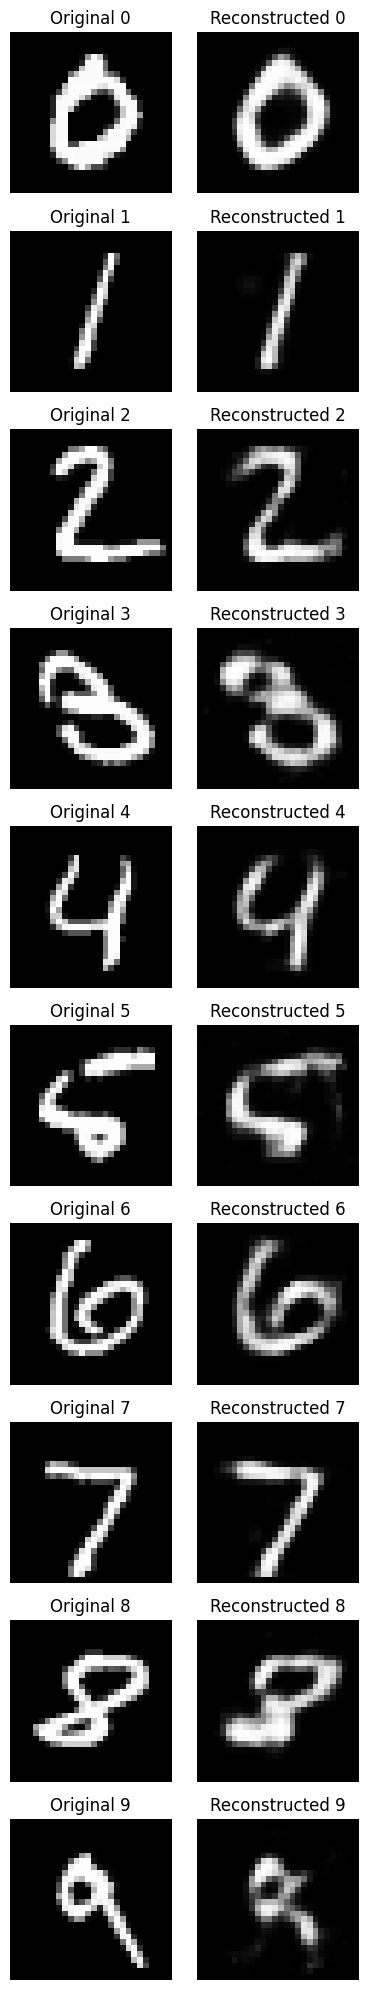

/tmp/ipykernel_7600/1046858059.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


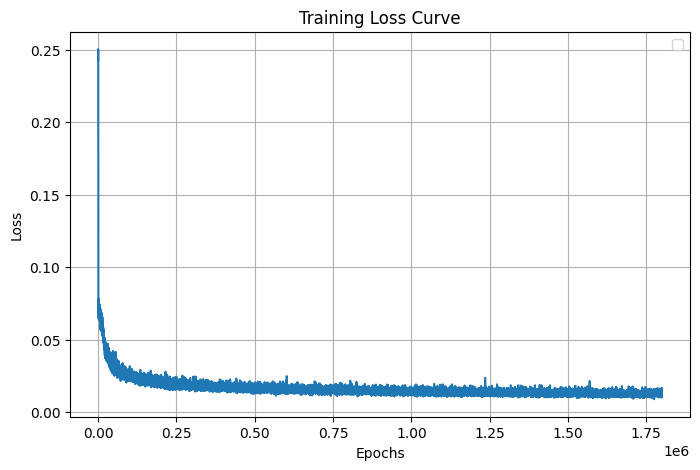

In [12]:
(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28*28) / 255.0
x_test = x_test.reshape(-1, 28*28) / 255.0

print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Encoder architecture 
encoder_arch = [(128, 'relu'), (32, 'tanh')]

autoencoder = MLPAutoencoder(784, encoder_arch, use_adam=False)
samples_seen, losses = autoencoder.train(x_train, epochs=30, batch_size=64, lr=0.05, run_name="mnist_autoencoder")

fig, axes = plt.subplots(10, 2, figsize=(4, 20))
for digit in range(10):
    idx = np.where(y_test == digit)[0][0]
    orig = x_test[idx]
    recon = autoencoder.forward(orig.reshape(1, -1)).reshape(28, 28)
    axes[digit, 0].imshow(orig.reshape(28, 28), cmap='gray')
    axes[digit, 0].set_title(f'Original {digit}')
    axes[digit, 0].axis('off')
    axes[digit, 1].imshow(recon, cmap='gray')
    axes[digit, 1].set_title(f'Reconstructed {digit}')
    axes[digit, 1].axis('off')
plt.tight_layout()
plt.show()

#Loss curve
plt.figure(figsize=(8, 5))
plt.plot(samples_seen, losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid()
plt.show()

x_train shape: (60000, 784), x_test shape: (10000, 784)
y_test shape: (10000,)


Training: 100%|████████████████████████████| 30/30 [03:09<00:00,  6.33s/it, epoch=30, loss=0.010034]


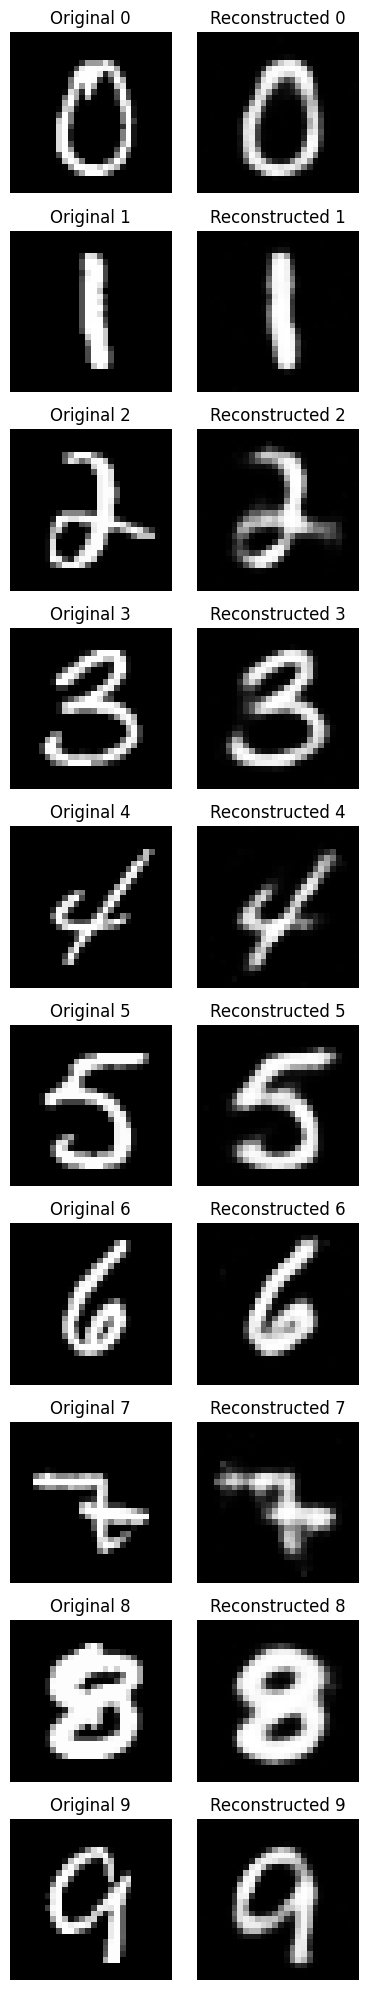

/tmp/ipykernel_7600/3159568478.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


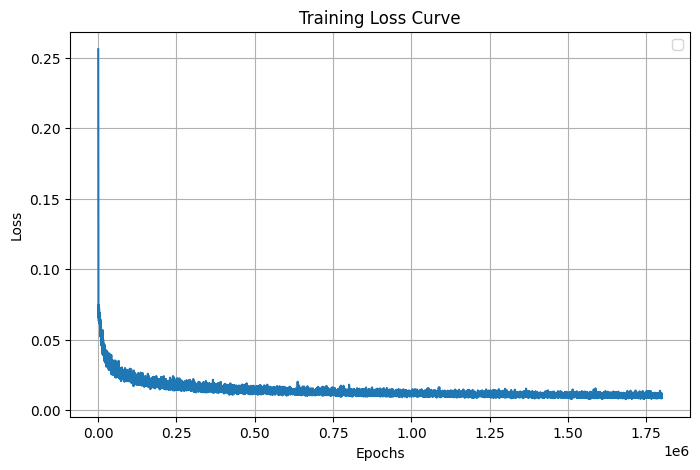

In [14]:
(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28*28) / 255.0
x_test = x_test.reshape(-1, 28*28) / 255.0

print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Encoder architecture 
encoder_arch = [(256, 'relu'), (128, 'relu'), (32, 'tanh')]

autoencoder = MLPAutoencoder(784, encoder_arch, use_adam=False)
samples_seen, losses = autoencoder.train(x_train, epochs=30, batch_size=64, lr=0.03, run_name="mnist_autoencoder_2")

fig, axes = plt.subplots(10, 2, figsize=(4, 20))
for digit in range(10):
    # Pick a random index of this digit
    idx = np.random.choice(np.where(y_test == digit)[0])
    
    orig = x_test[idx]
    recon = autoencoder.forward(orig.reshape(1, -1)).reshape(28, 28)
    
    axes[digit, 0].imshow(orig.reshape(28, 28), cmap='gray')
    axes[digit, 0].set_title(f'Original {digit}')
    axes[digit, 0].axis('off')
    
    axes[digit, 1].imshow(recon, cmap='gray')
    axes[digit, 1].set_title(f'Reconstructed {digit}')
    axes[digit, 1].axis('off')

plt.tight_layout()
plt.show()


#Loss curve
plt.figure(figsize=(8, 5))
plt.plot(samples_seen, losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid()
plt.show()

Found 530 George W Bush images
Found 12703 other images

Loading George W. Bush images...


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1792.04it/s]



Loading Other images...


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1900.20it/s]



Training with bottleneck dimension: 32


Training: 100%|████████████████████████████| 30/30 [06:41<00:00, 13.37s/it, epoch=30, loss=0.063768]



Results for bottleneck dimension 32:
AUC Score: 0.6160
Precision: 0.5963
Recall: 0.6500
F1-Score: 0.6220
Optimal Threshold: 0.0599

Training with bottleneck dimension: 64


Training: 100%|████████████████████████████| 30/30 [06:26<00:00, 12.88s/it, epoch=30, loss=0.064307]



Results for bottleneck dimension 64:
AUC Score: 0.6252
Precision: 0.6353
Recall: 0.5400
F1-Score: 0.5838
Optimal Threshold: 0.0685

Training with bottleneck dimension: 128


Training: 100%|████████████████████████████| 30/30 [06:16<00:00, 12.56s/it, epoch=30, loss=0.063696]



Results for bottleneck dimension 128:
AUC Score: 0.6310
Precision: 0.6923
Recall: 0.4500
F1-Score: 0.5455
Optimal Threshold: 0.0763


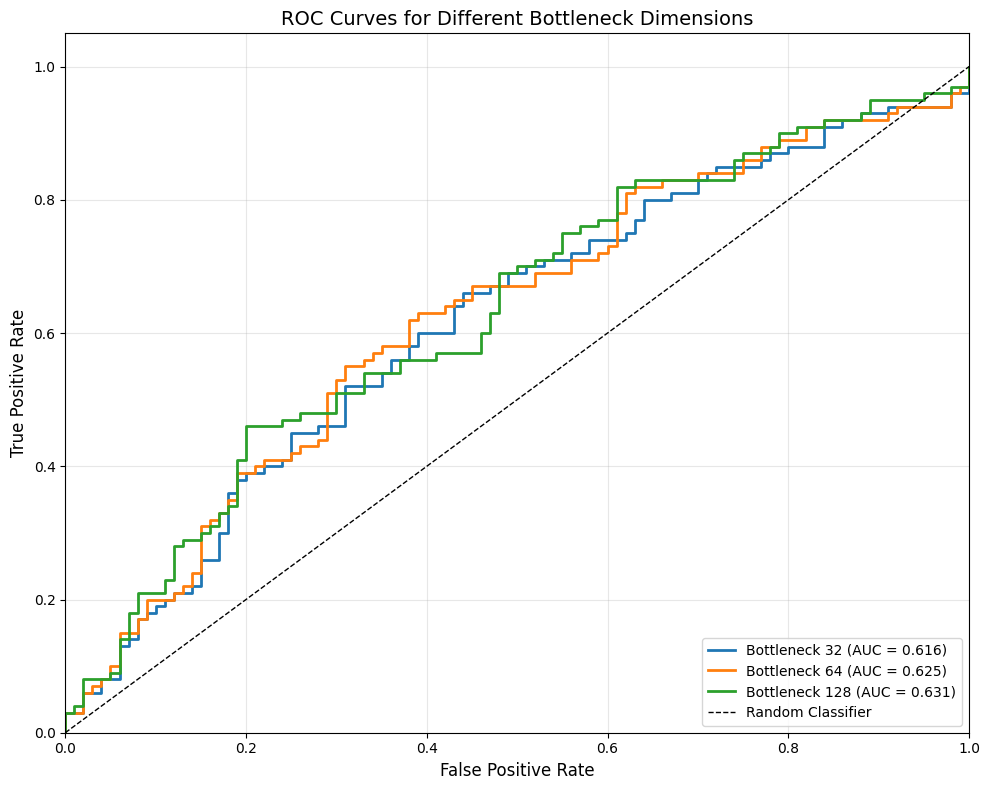


Best Model Visualization (Bottleneck 128)


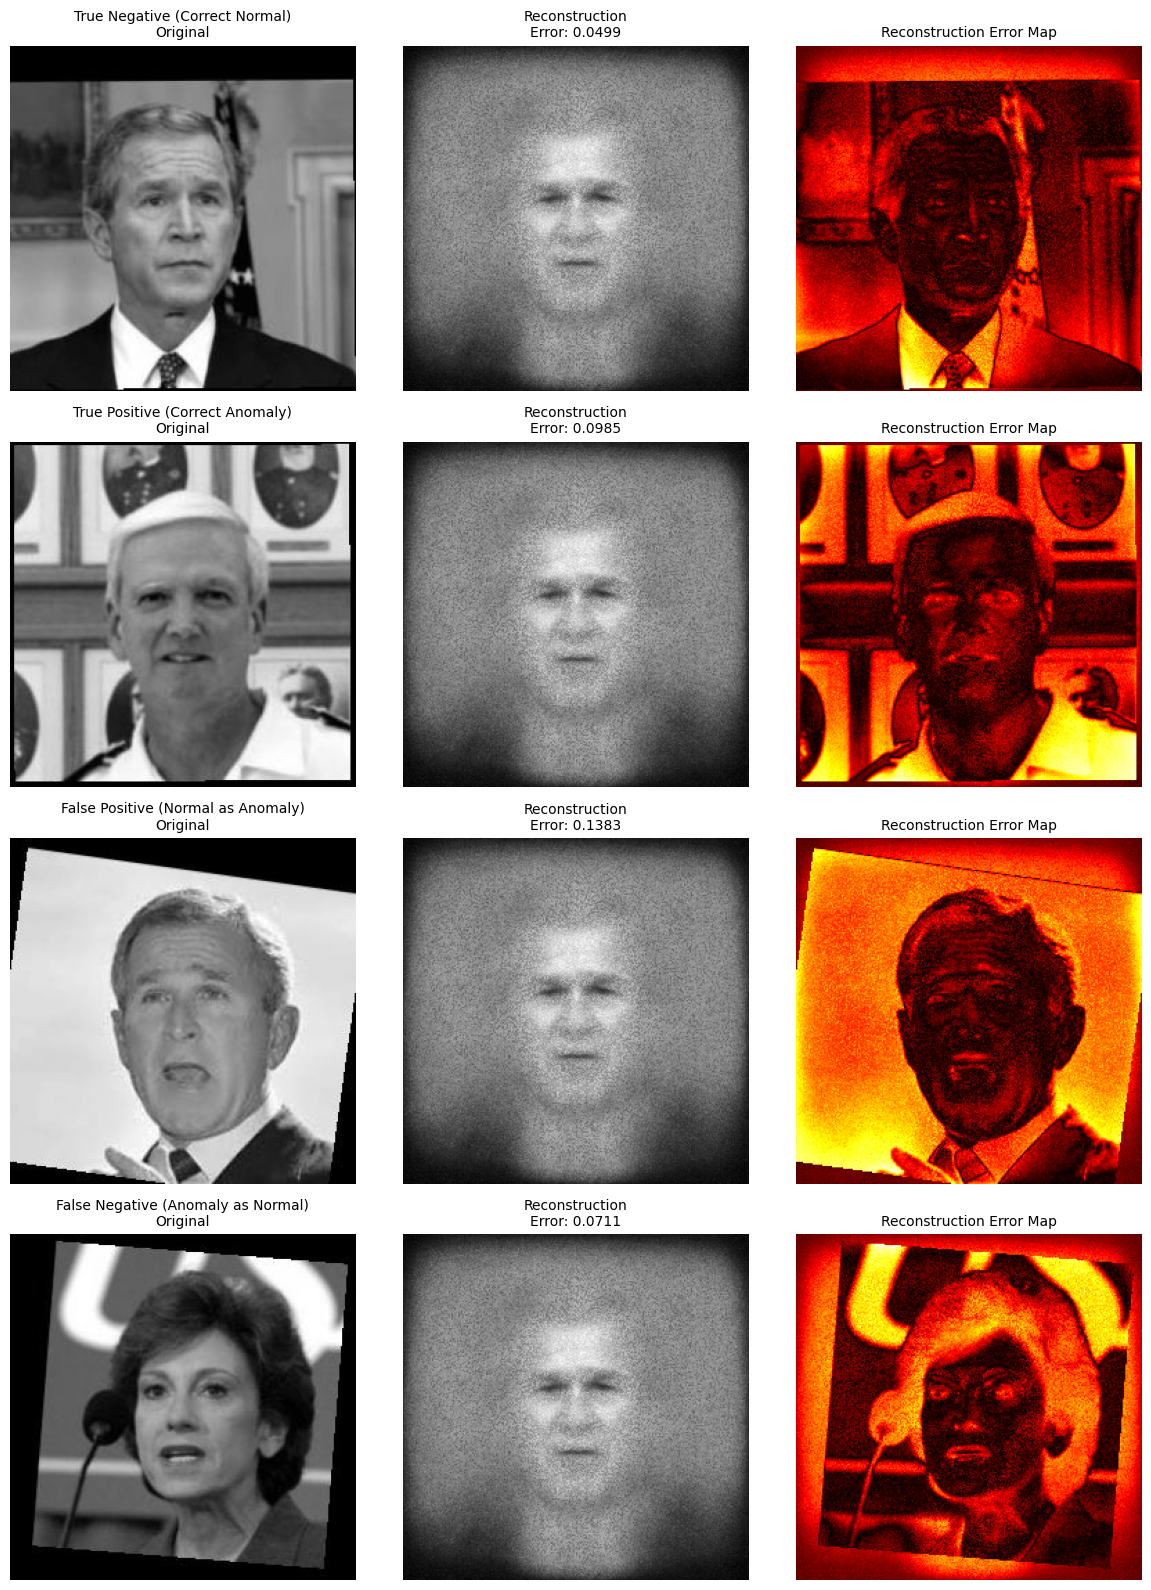

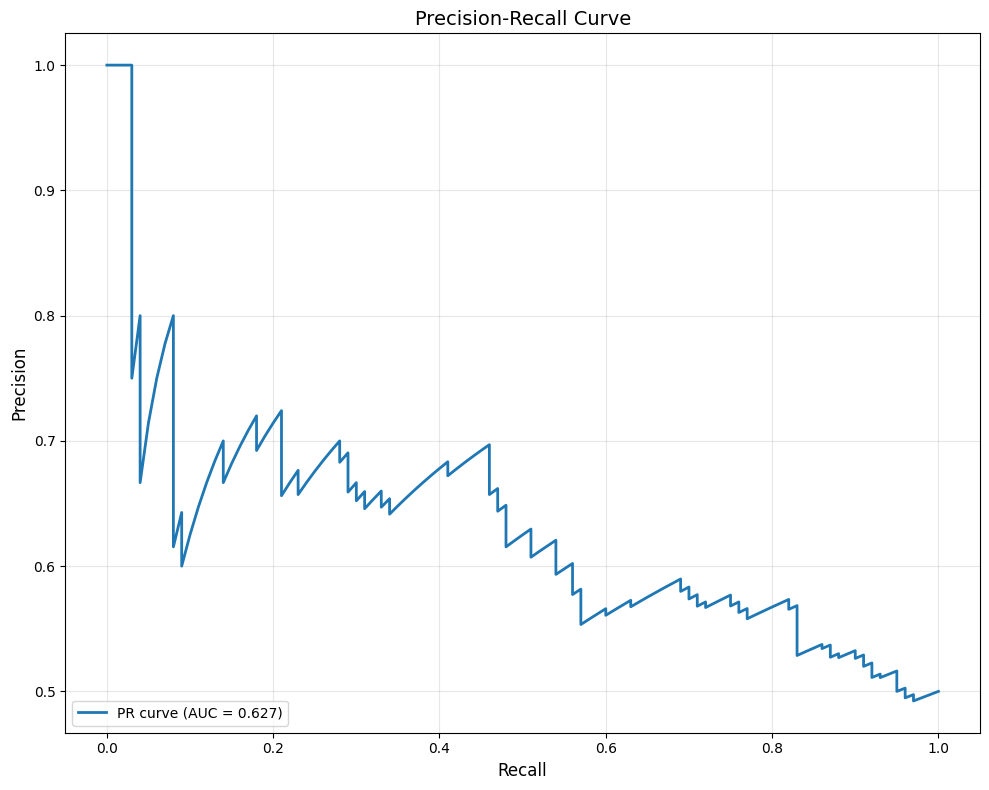

In [11]:
dataset = LFWDataset('Q3-20251007T170534Z-1-001/Q3/LFW_Dataset')
x_train, x_test, y_test = dataset.get_train_test_split(
    n_train=400, 
    n_test_normal=100, 
    n_test_anomaly=100
)

input_dim = x_train.shape[1]

# Test different bottleneck dimensions
bottleneck_dims = [32, 64, 128]
results = {}
best_autoencoder = None
best_result = None
best_auc = 0

for bottleneck_dim in bottleneck_dims:
    print(f"\n{'='*60}")
    print(f"Training with bottleneck dimension: {bottleneck_dim}")
    print(f"{'='*60}")
    
    run_name = f"lfw_autoencoder_{bottleneck_dim}"
    
    encoder_arch = [
        (512, 'relu'),
        (256, 'relu'),
        (bottleneck_dim, 'sigmoid')
    ]
    
    autoencoder = MLPAutoencoder(
        input_dim, 
        encoder_arch, 
        run_name=run_name, 
        use_adam=True
    )
    
    # Train model
    losses = autoencoder.train(
        x_train, 
        epochs=30, 
        batch_size=64, 
        lr=0.0005
    )
    
    # Evaluate
    result = evaluate_model(autoencoder, x_test, y_test)
    results[f'Bottleneck {bottleneck_dim}'] = result
    
    print(f"\nResults for bottleneck dimension {bottleneck_dim}:")
    print(f"AUC Score: {result['auc']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"Optimal Threshold: {result['threshold']:.4f}")
    
    if result['auc'] > best_auc:
        best_auc = result['auc']
        best_autoencoder = autoencoder
        best_result = result
        best_bottleneck = bottleneck_dim

# Plot results
plot_roc_curves(results)

print(f"\n{'='*60}")
print(f"Best Model Visualization (Bottleneck {best_bottleneck})")
print(f"{'='*60}")
visualize_results(best_autoencoder, x_test, y_test, best_result)
plot_pr_curve(best_result, y_test)